In [ ]:
import cv2
import numpy as np
import time
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

def Estimate_homography(keypoints_1, keypoints_2, matches):
    """Matches를 기반으로 Homography 추정하는 함수"""
    if len(matches) < 4:
        return None

    # src_pts_는 첫번째 이미지의 keypoint 픽셀, dst_pts_는 두번째 이미지의 keypoint 픽셀, 이 좌표들을 통해 첫번째 이미지의 평면을 두번째 이미지의 평면으로 변환
    src_pts_ = np.float32([keypoints_1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts_ = np.float32([keypoints_2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Calculate homography matrix using RANSAC
    H_, mask_ = cv2.findHomography(src_pts_, dst_pts_, cv2.RANSAC, 3.0)
    return H_, mask_, src_pts_, dst_pts_


def Apply_Homography(keypoints, H):
    #Apply the Homography matrix to the given keypoints.

    # Convert keypoints to homogeneous coordinates
    pts = np.float32([kp.pt for kp in keypoints]).reshape(-1, 1, 2)

    # Apply the Homography matrix
    transformed_pts = cv2.perspectiveTransform(pts, H)

    return transformed_pts[:, 0, :]

def Apply_Inverse_Homography(keypoints, H):
    """Apply the inverse Homography matrix to the given keypoints."""
    # Compute inverse of Homography matrix
    H_inv = np.linalg.inv(H)

    # Convert keypoints to homogeneous coordinates
    pts = np.float32([kp.pt for kp in keypoints]).reshape(-1, 1, 2)

    # Apply the inverse Homography matrix
    transformed_pts = cv2.perspectiveTransform(pts, H_inv)

    return transformed_pts[:, 0, :]


def Calculate_Repeatability_Homography(keypoints_1, keypoints_2, H, distance_threshold=3.0):
    """Reference(keypoints_1)와 Test Keypoints(keypoints_2) 간 repeatability 계산 (Inverse Homography 적용)"""
    if len(keypoints_1) == 0 or len(keypoints_2) == 0:
        return 0.0

    # Test image의 keypoints를 Reference image 좌표계로 변환
    transformed_pts2 = Apply_Inverse_Homography(keypoints_2, H)
    pts1 = np.float32([kp.pt for kp in keypoints_1])

    repeatable_points = 0

    # Check for repeatable points using transformed test keypoints
    for pt2 in transformed_pts2:
        distances = np.linalg.norm(pts1 - pt2, axis=1)
        if np.min(distances) < distance_threshold:
            repeatable_points += 1

    repeatability = (repeatable_points / len(pts1)) * 100
    return repeatability


def Calculate_scale_space_Repeatability_Homography(keypoints_1, keypoints_2, H, distance_threshold=3.0):
    """Scale space를 고려한 Repeatability 계산 (Inverse Homography 적용)"""
    if len(keypoints_1) == 0 or len(keypoints_2) == 0:
        return 0.0

    ss_repeatable_points = 0

    # Test image의 keypoints를 Reference image 좌표계로 변환
    transformed_pts2 = Apply_Inverse_Homography(keypoints_2, H)

    for idx, kp2 in enumerate(keypoints_2):
        pt2 = transformed_pts2[idx]
        size2 = kp2.size

        for kp1 in keypoints_1:
            pt1 = np.array(kp1.pt)
            size1 = kp1.size

            spatial_dist = np.linalg.norm(pt1 - pt2)
            scale_ratio = min(size1, size2) / max(size1, size2)

            if spatial_dist < distance_threshold and scale_ratio > 0.8:
                ss_repeatable_points += 1
                break

    ss_repeatability = (ss_repeatable_points / len(keypoints_2)) * 100
    return ss_repeatability


def Calculate_metrics_Homography(keypoints_1, keypoints_2, matches, H, reference_img, test_img, detection_time, matching_time, distance_threshold=3.0):
    """Homography 기반 Evaluation metric 계산 (Inverse Homography 적용)"""
    if H is None:
        H, _, _, _ = Estimate_homography(keypoints_1, keypoints_2, matches)

    # Matches Percentage 계산
    total_possible_matches = min(len(keypoints_1), len(keypoints_2))
    matches_percentage = (len(matches) / total_possible_matches) * 100

    # Test image의 matched keypoints를 Reference image 좌표계로 변환
    test_points = np.float32([keypoints_2[m.trainIdx].pt for m in matches])
    transformed_test_points = Apply_Inverse_Homography([keypoints_2[m.trainIdx] for m in matches], H)
    reference_points = np.float32([keypoints_1[m.queryIdx].pt for m in matches])

    # Correct Matches calculation based on transformed points
    point_distances = np.linalg.norm(transformed_test_points - reference_points, axis=1)
    correct_matches = point_distances < distance_threshold
    correct_matches_count = np.sum(correct_matches)

    # Precision, Recall, and F1 Score
    precision = (correct_matches_count / len(matches)) * 100 if len(matches) > 0 else 0
    recall = (correct_matches_count / len(keypoints_1)) * 100 if len(keypoints_1) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Average localization error
    avg_localization_error = np.mean(point_distances) if len(point_distances) > 0 else float('inf')

    # Repeatability calculations
    repeatability = Calculate_Repeatability_Homography(keypoints_1, keypoints_2, H, distance_threshold)
    ss_repeatability = Calculate_scale_space_Repeatability_Homography(keypoints_1, keypoints_2, H, distance_threshold)

    # Combine metrics
    metrics = {
        'num_keypoints_reference': len(keypoints_1),
        'num_keypoints_test': len(keypoints_2),
        'num_matches': len(matches),
        'matches_percentage': matches_percentage,
        'correct_matches_percentage(precision)': precision,
        'num_correct_matches': correct_matches_count,
        'recall': recall,
        'f1_score': f1_score,
        'avg_localization_error': avg_localization_error,
        'repeatability': repeatability,
        'scale_space_repeatability': ss_repeatability,
        'detection_time_ms': detection_time * 1000,
        'matching_time_ms': matching_time * 1000,
        'total_processing_time': (detection_time + matching_time) * 1000
    }

    return metrics, correct_matches, H


def Visualize_metrics_Homography(reference_img, test_img, keypoints_1, keypoints_2, matches, correct_matches, metrics, H):
    """Evaluation metrics 시각화 (Inverse Homography 적용)"""
    plt.figure(figsize=(20, 12))

    # Plot 1: All matches
    plt.subplot(2, 2, 1)
    matched_img = cv2.drawMatches(reference_img, keypoints_1, test_img, keypoints_2, matches, None, flags=2)
    plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
    plt.title('All Matches')

    # Plot 2: Correct matches only
    correct_matches_list = [m for i, m in enumerate(matches) if correct_matches[i]]
    plt.subplot(2, 2, 2)
    good_matched_img = cv2.drawMatches(reference_img, keypoints_1, test_img, keypoints_2, correct_matches_list, None, flags=2)
    plt.imshow(cv2.cvtColor(good_matched_img, cv2.COLOR_BGR2RGB))
    plt.title('Correct Matches')

    # Plot 3: Performance metrics
    plt.subplot(2, 2, 3)
    metric_names = ['correct_matches_percentage(precision)', 'recall', 'f1_score', 'repeatability', 'scale_space_repeatability']
    metric_values = [metrics[name] for name in metric_names]
    plt.bar(metric_names, metric_values)
    plt.title('Performance Metrics')
    plt.xticks(rotation=45)

    # Plot 4: Keypoint distribution with inverse Homography-transformed keypoints
    plt.subplot(2, 2, 4)
    # Test image의 모든 keypoints를 Reference image 좌표계로 변환
    transformed_keypoints_2 = Apply_Inverse_Homography(keypoints_2, H)

    plt.imshow(cv2.cvtColor(reference_img, cv2.COLOR_BGR2RGB))
    plt.scatter([kp.pt[0] for kp in keypoints_1], [kp.pt[1] for kp in keypoints_1],
                c='g', s=20, alpha=0.5, label='Reference Keypoints')
    plt.scatter([pt[0] for pt in transformed_keypoints_2], [pt[1] for pt in transformed_keypoints_2],
                c='b', s=20, alpha=0.5, label='Transformed Test Keypoints')
    plt.legend()
    plt.title('Keypoint Distribution in Reference Image Space')

    plt.tight_layout()
    plt.show()

def Print_metrics(metrics):
    """결과 출력"""
    print("\nFeature Detection and Matching Evaluation:")
    print("="*50)

    print("\nFeature Detection Metrics:")
    print(f"Number of keypoints (Reference): {metrics['num_keypoints_reference']}")
    print(f"Number of keypoints (Test): {metrics['num_keypoints_test']}")
    print(f"Detection time: {metrics['detection_time_ms']:.2f} ms")

    print("\nMatching Metrics:")
    print(f"Total matches: {metrics['num_matches']}")
    print(f"Matches percentage: {metrics['matches_percentage']:.2f}%")
    print(f"Matching time: {metrics['matching_time_ms']:.2f} ms")

    print("\nPerformance Metrics:")
    print(f"Correct matches count: {metrics['num_correct_matches']}")
    print(f"Correct Matches percentage: {metrics['correct_matches_percentage(precision)']:.2f}%")
    print(f"Recall: {metrics['recall']:.2f}%")
    print(f"F1 Score: {metrics['f1_score']:.2f}%")
    print(f"Average localization error: {metrics['avg_localization_error']:.2f} pixels")
    print(f"Repeatability: {metrics['repeatability']:.2f}%")
    print(f"Scale-space repeatability: {metrics['scale_space_repeatability']:.2f}%")
    print(f"Total processing time: {metrics['total_processing_time']:.2f} ms")
    print("="*50)
    print("\n")

"""================================================================================================================="""

#image 설정
img1 = cv2.imread('org.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('ctrct.png', cv2.IMREAD_GRAYSCALE)

"""
# Load the original image in grayscale
img1 = cv2.imread('lenna.png', cv2.IMREAD_GRAYSCALE)

scale = 3;
# Check if the image was loaded successfully
if img1 is None:
    print("Error: Could not load image.")
else:
    # Get the original dimensions
    original_height, original_width = img1.shape

    # Scale down the image to half its size
    scaled_down_img = cv2.resize(img1, (original_width // scale, original_height // scale))

    # Scale up the image to twice its scaled-down size (which equals the original size)
    scaled_up_img = cv2.resize(scaled_down_img, (original_width * scale, original_height * scale))

    # Calculate cropping coordinates to get the center of the scaled-up image
    x_start = (scaled_up_img.shape[1] - original_width) // scale
    y_start = (scaled_up_img.shape[0] - original_height) // scale

    # Crop the image to the original size
    cropped_img = scaled_up_img[y_start:y_start + original_height, x_start:x_start + original_width]

    # Display the cropped image
    cv2_imshow(cropped_img)
    img2 =cropped_img
    """
"""
# Load the original image in grayscale
img1 = cv2.imread('lenna.png', cv2.IMREAD_GRAYSCALE)

# Get the original dimensions
original_height, original_width = img1.shape

# Scale down the image to half its size
scaled_img = cv2.resize(img1, (original_width // 2, original_height // 2))

# Create a black background with the same size as the original image
background = np.zeros((original_height, original_width), dtype=np.uint8)

# Calculate the starting point to center the scaled image
x_offset = (original_width - scaled_img.shape[1]) // 2
y_offset = (original_height - scaled_img.shape[0]) // 2

# Place the scaled image in the center of the black background
background[y_offset:y_offset + scaled_img.shape[0], x_offset:x_offset + scaled_img.shape[1]] = scaled_img

cv2_imshow(background)

img2 = background;
"""

#Ground Truth Homography 입력(알고 있을 경우에만, Homography(기하학적 변화)가 없다면 H를 [[1,0,0],[0,1,0],[0,0,1]]로 입력, 아예 모른다면 H를 None으로 입력)
GTH = None
#GTH = np.array([[1,0,0],[0,1,0],[0,0,1]])
#GTH = np.array([[888.936371179244e-003,18.2514352297355e-003,8.97590117321321e+000],[4.65426880548969e-003,921.643538138129e-003,7.37848417972965e+000],[11.5540704210687e-006,71.2845423476733e-006,1.00068189116337e+000]])

#Brute Force Matcher
def BFMatcher_SIFT(img1, img2, keypoints_1, keypoints_2, descriptors_1, descriptors_2):

  #Brute Force Matcher 사용(SIFT에서)
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

  #BF를 활용해서 matching 진행
  start_match = time.time()
  matches = bf.match(descriptors_1, descriptors_2)
  end_match = time.time()

  match_result = sorted(matches, key = lambda x:x.distance)
  matched_img = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, match_result, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

  return descriptors_1, descriptors_2, match_result, matched_img, start_match, end_match

#Brute Force Matcher at binary
def BFMatcher_bi(img1, img2, keypoints_1, keypoints_2, descriptors_1, descriptors_2):

  #Brute Force Matcher 사용(SIFT에서)
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

  #BF를 활용해서 matching 진행
  start_match = time.time()
  matches = bf.match(descriptors_1, descriptors_2)
  end_match = time.time()

  match_result = sorted(matches, key = lambda x:x.distance)
  matched_img = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, match_result, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

  return descriptors_1, descriptors_2, match_result, matched_img, start_match, end_match

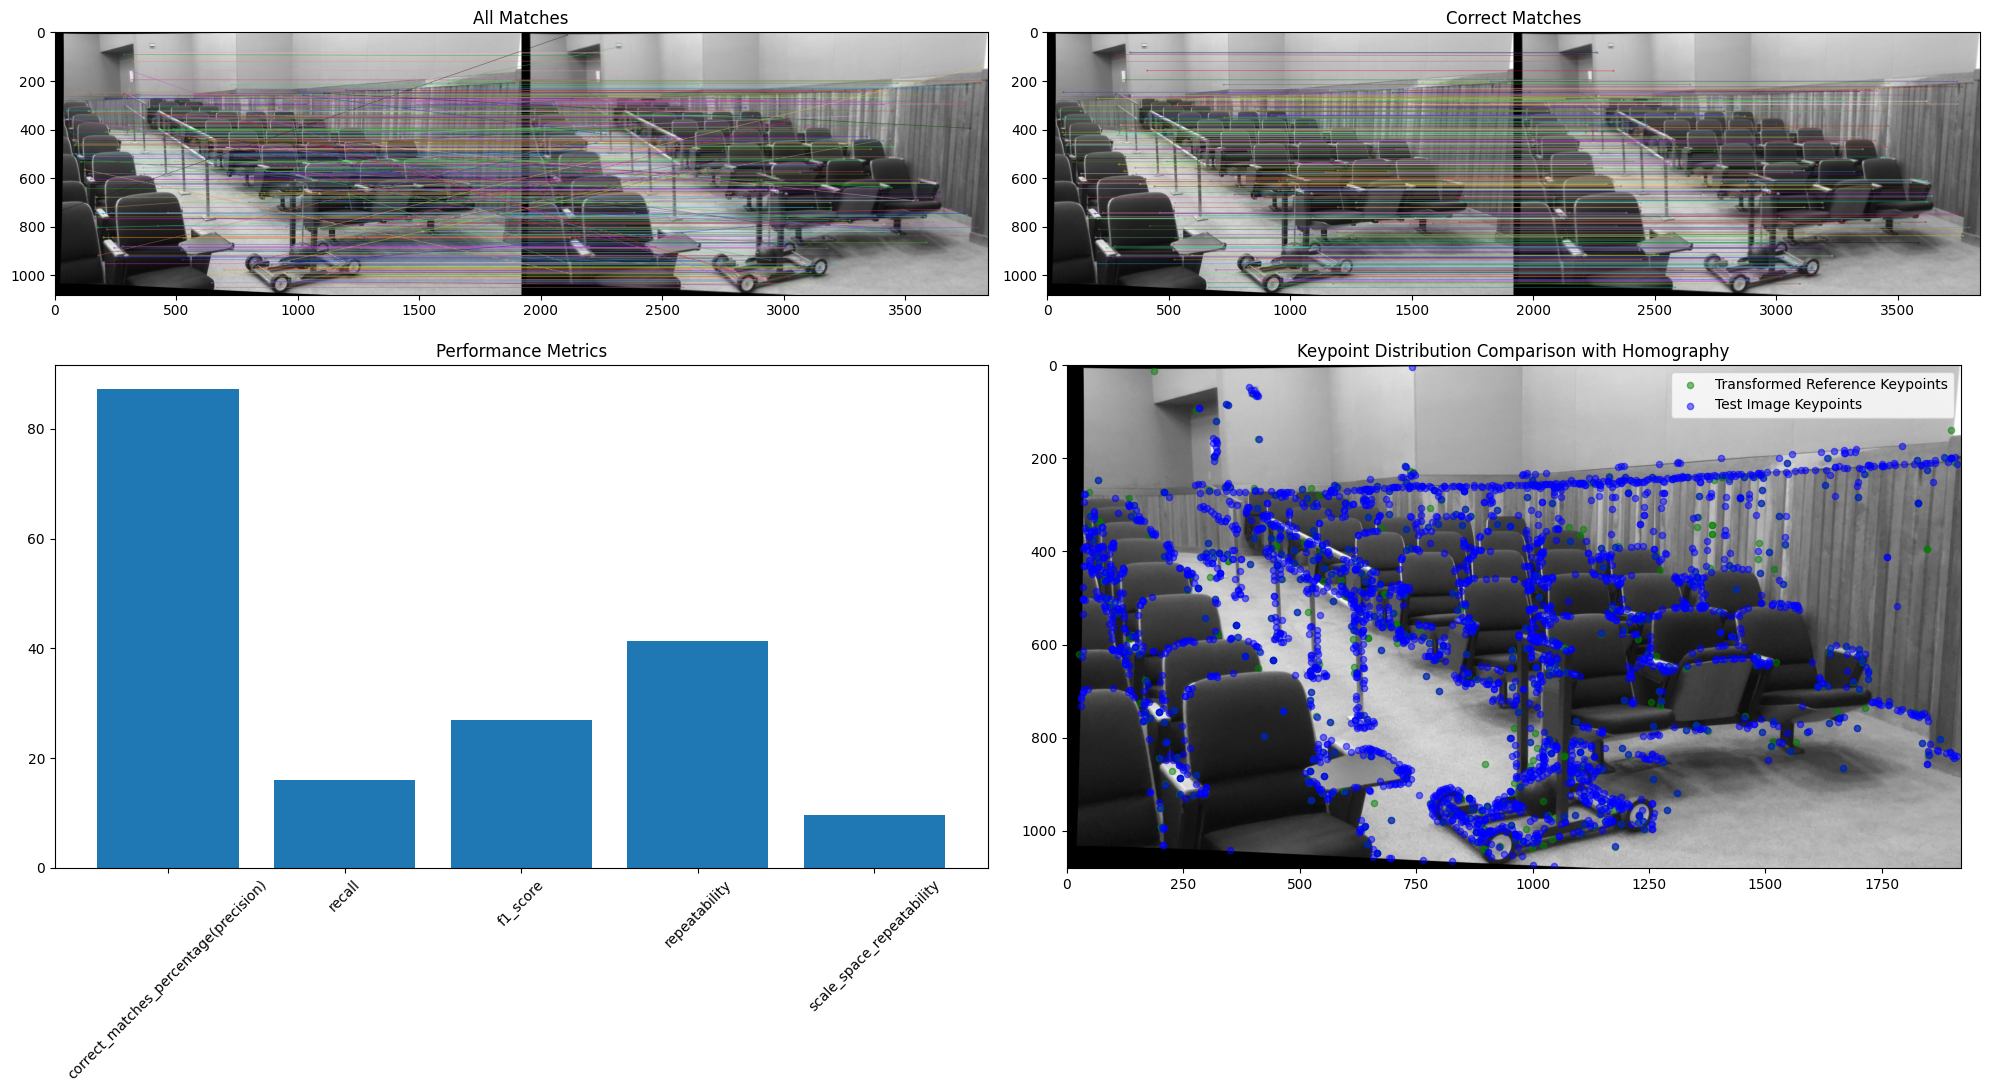


Feature Detection and Matching Evaluation:

Feature Detection Metrics:
Number of keypoints (Reference): 2588
Number of keypoints (Test): 552
Detection time: 885.06 ms

Matching Metrics:
Total matches: 472
Matches percentage: 85.51%
Matching time: 71.72 ms

Performance Metrics:
Correct matches count: 412
Correct Matches percentage: 87.29%
Recall: 15.92%
F1 Score: 26.93%
Average localization error: 16.89 pixels
Repeatability: 41.34%
Scale-space repeatability: 9.66%
Total processing time: 956.77 ms


[[ 2.49857570e-01 -5.97705439e-05 -1.39515054e-01]
 [-6.20242095e-05  2.49798639e-01 -7.32293271e-02]
 [-7.14001620e-08 -5.77869788e-07  1.00000000e+00]]


In [ ]:
#SIFT

import cv2
import time
from google.colab.patches import cv2_imshow

# 이미지가 제대로 로드되지 않은 경우 처리
if img1 is None or img2 is None:
    print("Could not open or find the images!")
    exit()

#SIFT 불러오기
sift = cv2.SIFT_create()

#keypoint와 descriptor를 추출하고 걸리는 시간도 함께 측정
start = time.time()
keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2, None)
end = time.time()


descriptors_1, descriptors_2, match_result, matched_img, start_match, end_match = BFMatcher_SIFT(img1, img2, keypoints_1, keypoints_2, descriptors_1, descriptors_2)

print("="*50)
metrics, correct_matches, CH = Calculate_metrics_Homography(keypoints_1, keypoints_2, match_result, GTH, img1, img2, (end - start), (end_match - start_match))
Visualize_metrics_Homography(img1, img2, keypoints_1, keypoints_2, match_result, correct_matches, metrics, CH)
Print_metrics(metrics)
print(CH)

In [ ]:
import cv2

# 좌표 배열 (예시)
keypoint_coords = [
    [26.70018, 619.93445],
    [46.40784, 272.53217],
    [46.462303, 349.08005],
    [1885.3951, 198.62172],
    [1899.7334, 139.0543],
    [1904.3116, 209.03914]
]

# cv2.KeyPoint 객체 리스트로 변환
keypoints = [cv2.KeyPoint(x=coord[0], y=coord[1], size=1) for coord in keypoint_coords]

# 결과 확인
print(keypoints)

[< cv2.KeyPoint 0x7e8304f76040>, < cv2.KeyPoint 0x7e8304f77e40>, < cv2.KeyPoint 0x7e8304f77000>, < cv2.KeyPoint 0x7e8304f77720>, < cv2.KeyPoint 0x7e8304f747b0>, < cv2.KeyPoint 0x7e8304f75aa0>]


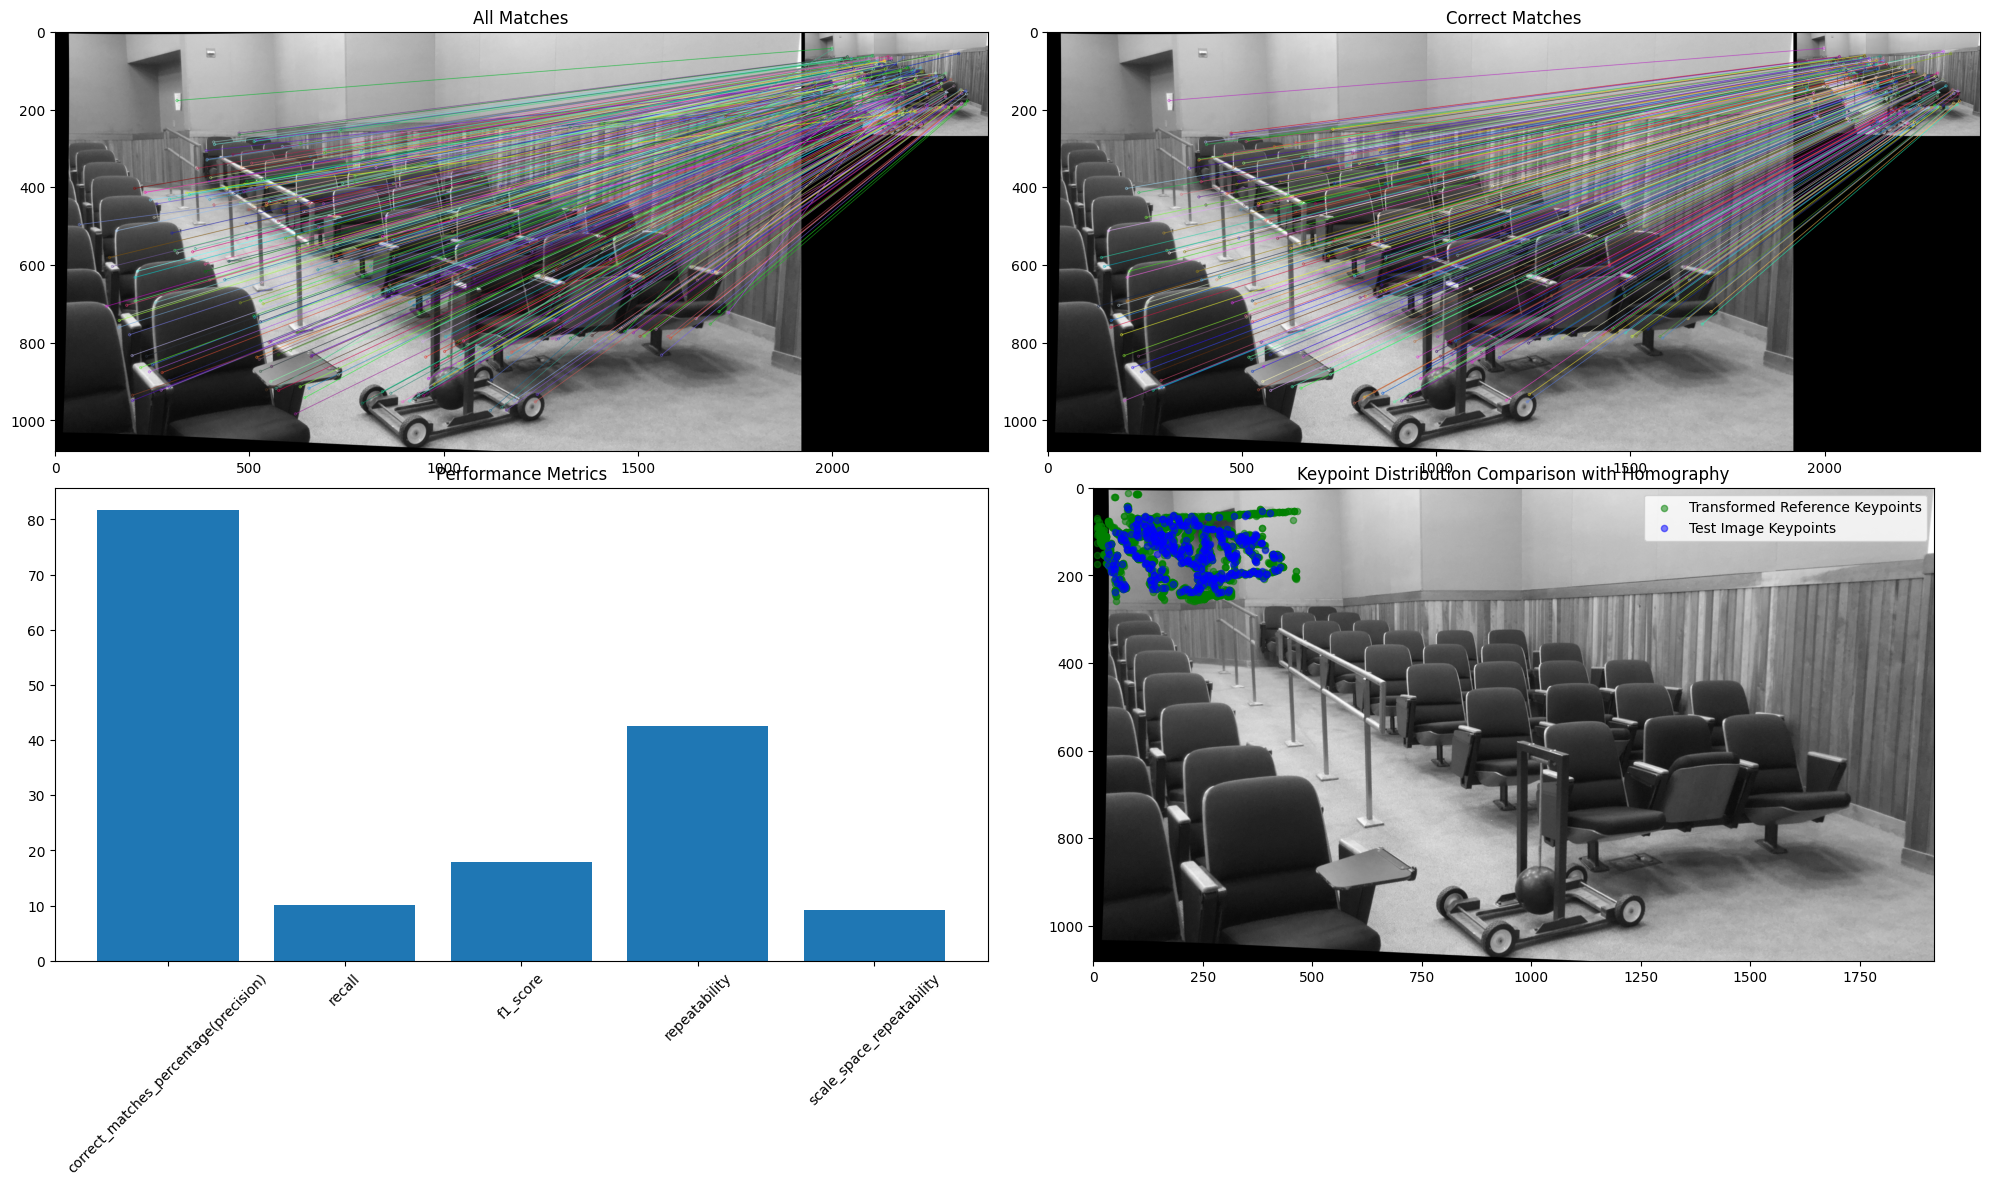


Feature Detection and Matching Evaluation:

Feature Detection Metrics:
Number of keypoints (Reference): 2784
Number of keypoints (Test): 406
Detection time: 540.67 ms

Matching Metrics:
Total matches: 344
Matches percentage: 84.73%
Matching time: 45.42 ms

Performance Metrics:
Correct matches count: 281
Correct Matches percentage: 81.69%
Recall: 10.09%
F1 Score: 17.97%
Average localization error: 21.92 pixels
Repeatability: 42.53%
Scale-space repeatability: 9.12%
Total processing time: 586.09 ms


[[ 2.50119994e-01  3.07395225e-04 -5.49965276e-01]
 [ 2.49613303e-06  2.50276875e-01 -3.86835966e-01]
 [-1.76646405e-07  1.24198562e-06  1.00000000e+00]]


In [ ]:
#AKAZE

import cv2
import time
from google.colab.patches import cv2_imshow

# 이미지가 제대로 로드되지 않은 경우 처리
if img1 is None or img2 is None:
    print("Could not open or find the images!")
    exit()


# AKAZE 특징점 검출기 생성
akaze = cv2.AKAZE_create()

# 특징점과 디스크립터 추출
start = time.time()
keypoints_1, descriptors_1 = akaze.detectAndCompute(img1, None)
keypoints_2, descriptors_2 = akaze.detectAndCompute(img2, None)
end = time.time()


descriptors_1, descriptors_2, match_result, matched_img, start_match, end_match = BFMatcher_bi(img1, img2, keypoints_1, keypoints_2, descriptors_1, descriptors_2)


print("="*50)
metrics, correct_matches, CH = Calculate_metrics_Homography(keypoints_1, keypoints_2, match_result, GTH, img1, img2, (end - start), (end_match - start_match))
Visualize_metrics_Homography(img1, img2, keypoints_1, keypoints_2, match_result, correct_matches, metrics, CH)
Print_metrics(metrics)
print(CH)

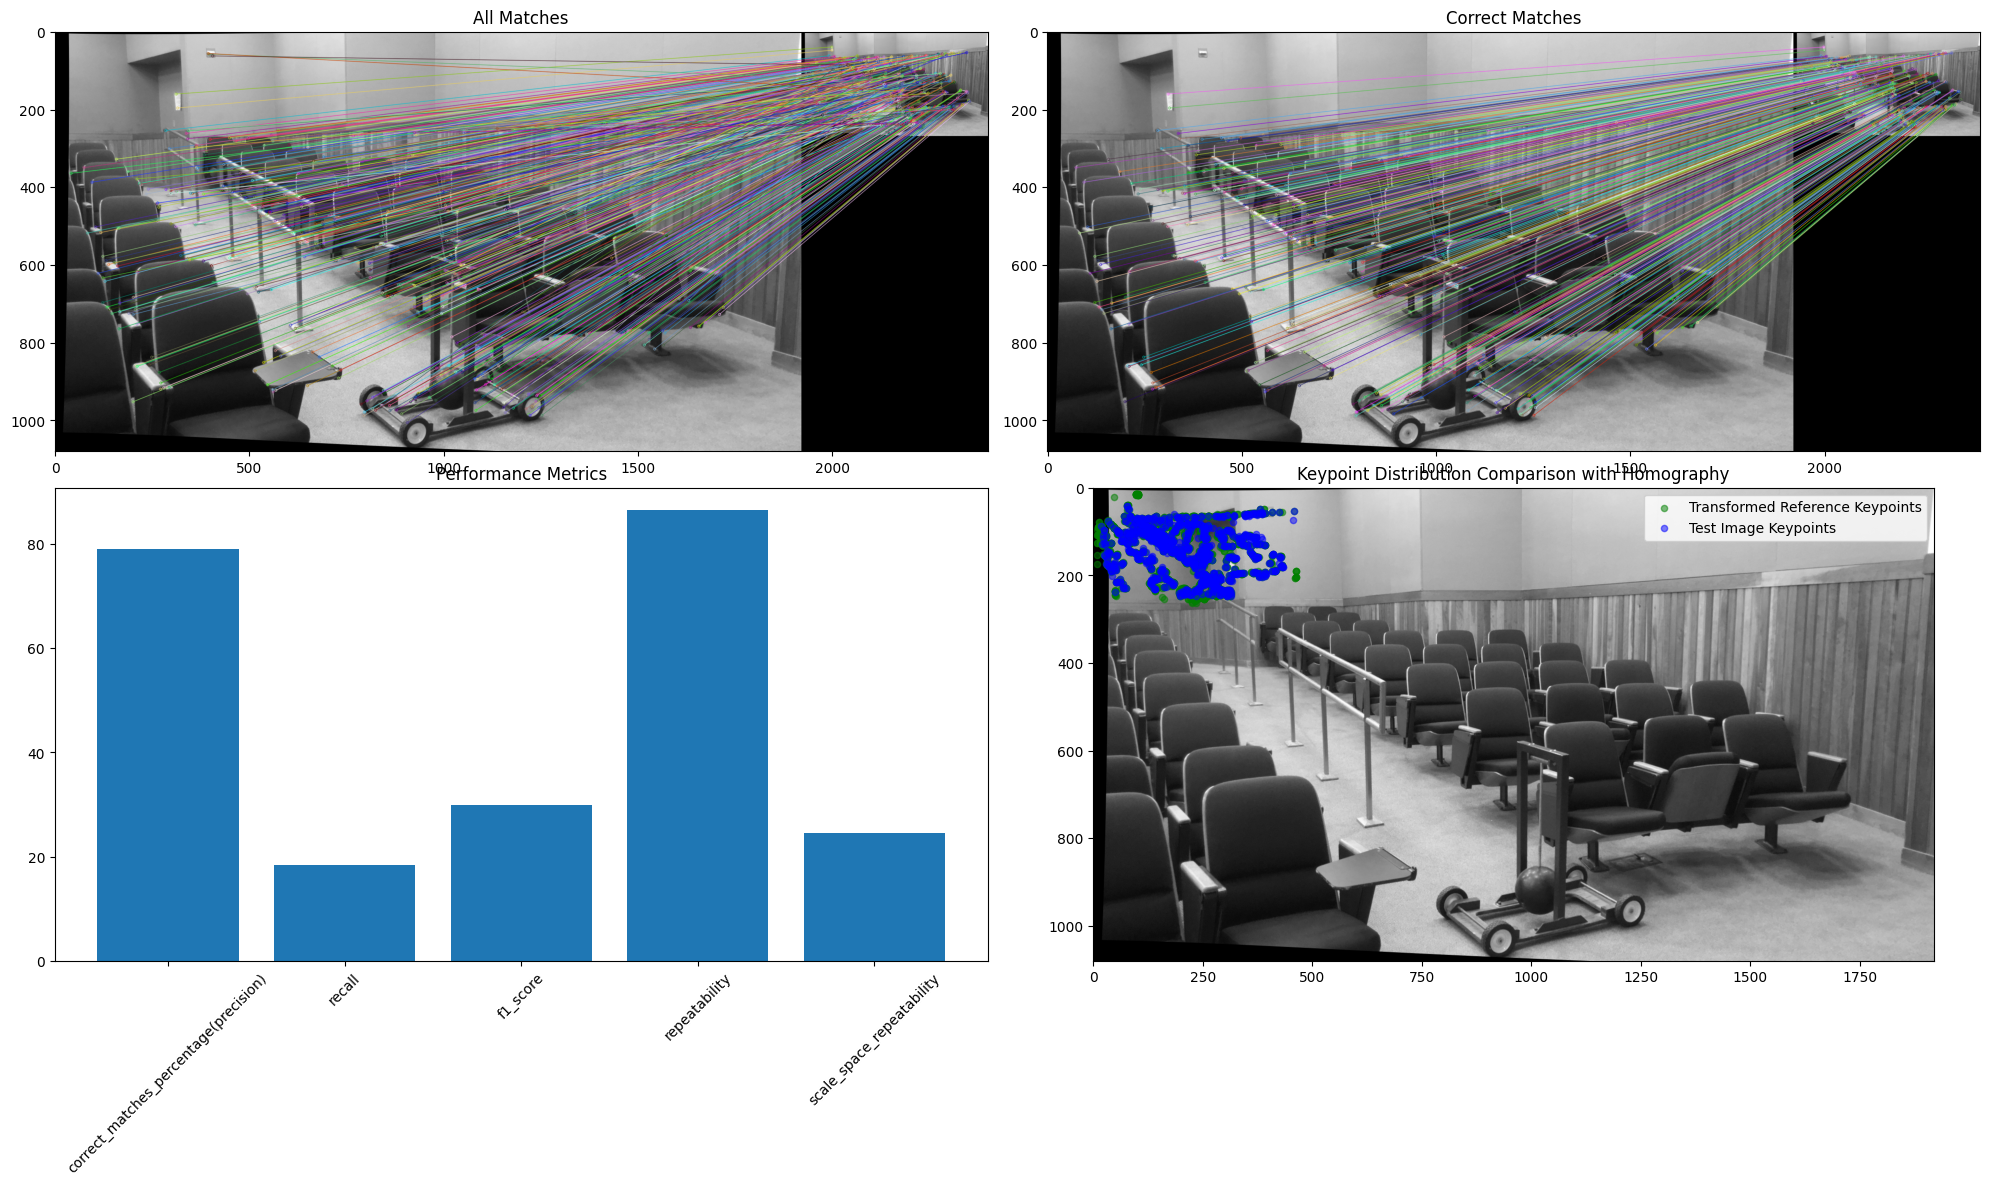


Feature Detection and Matching Evaluation:

Feature Detection Metrics:
Number of keypoints (Reference): 2369
Number of keypoints (Test): 945
Detection time: 117.97 ms

Matching Metrics:
Total matches: 553
Matches percentage: 58.52%
Matching time: 72.09 ms

Performance Metrics:
Correct matches count: 437
Correct Matches percentage: 79.02%
Recall: 18.45%
F1 Score: 29.91%
Average localization error: 27.72 pixels
Repeatability: 86.53%
Scale-space repeatability: 24.61%
Total processing time: 190.06 ms


[[ 2.50000631e-01  2.90699688e-04 -4.65007877e-01]
 [-3.30396426e-05  2.50016064e-01 -2.83130194e-01]
 [-2.96295196e-07  1.12230846e-06  1.00000000e+00]]


In [ ]:
#BRISK

import cv2
import time
from google.colab.patches import cv2_imshow

# 이미지가 제대로 로드되지 않은 경우 처리
if img1 is None or img2 is None:
    print("Could not open or find the images!")
    exit()

# BRISK 특징점 검출기 생성
brisk = cv2.BRISK_create()

# 특징점과 디스크립터 추출
start = time.time()
keypoints_1, descriptors_1 = brisk.detectAndCompute(img1, None)
keypoints_2, descriptors_2 = brisk.detectAndCompute(img2, None)
end = time.time()

descriptors_1, descriptors_2, match_result, matched_img, start_match, end_match = BFMatcher_bi(img1, img2, keypoints_1, keypoints_2, descriptors_1, descriptors_2)


print("="*50)
metrics, correct_matches, CH = Calculate_metrics_Homography(keypoints_1, keypoints_2, match_result, GTH, img1, img2, (end - start), (end_match - start_match))
Visualize_metrics_Homography(img1, img2, keypoints_1, keypoints_2, match_result, correct_matches, metrics, CH)
Print_metrics(metrics)
print(CH)

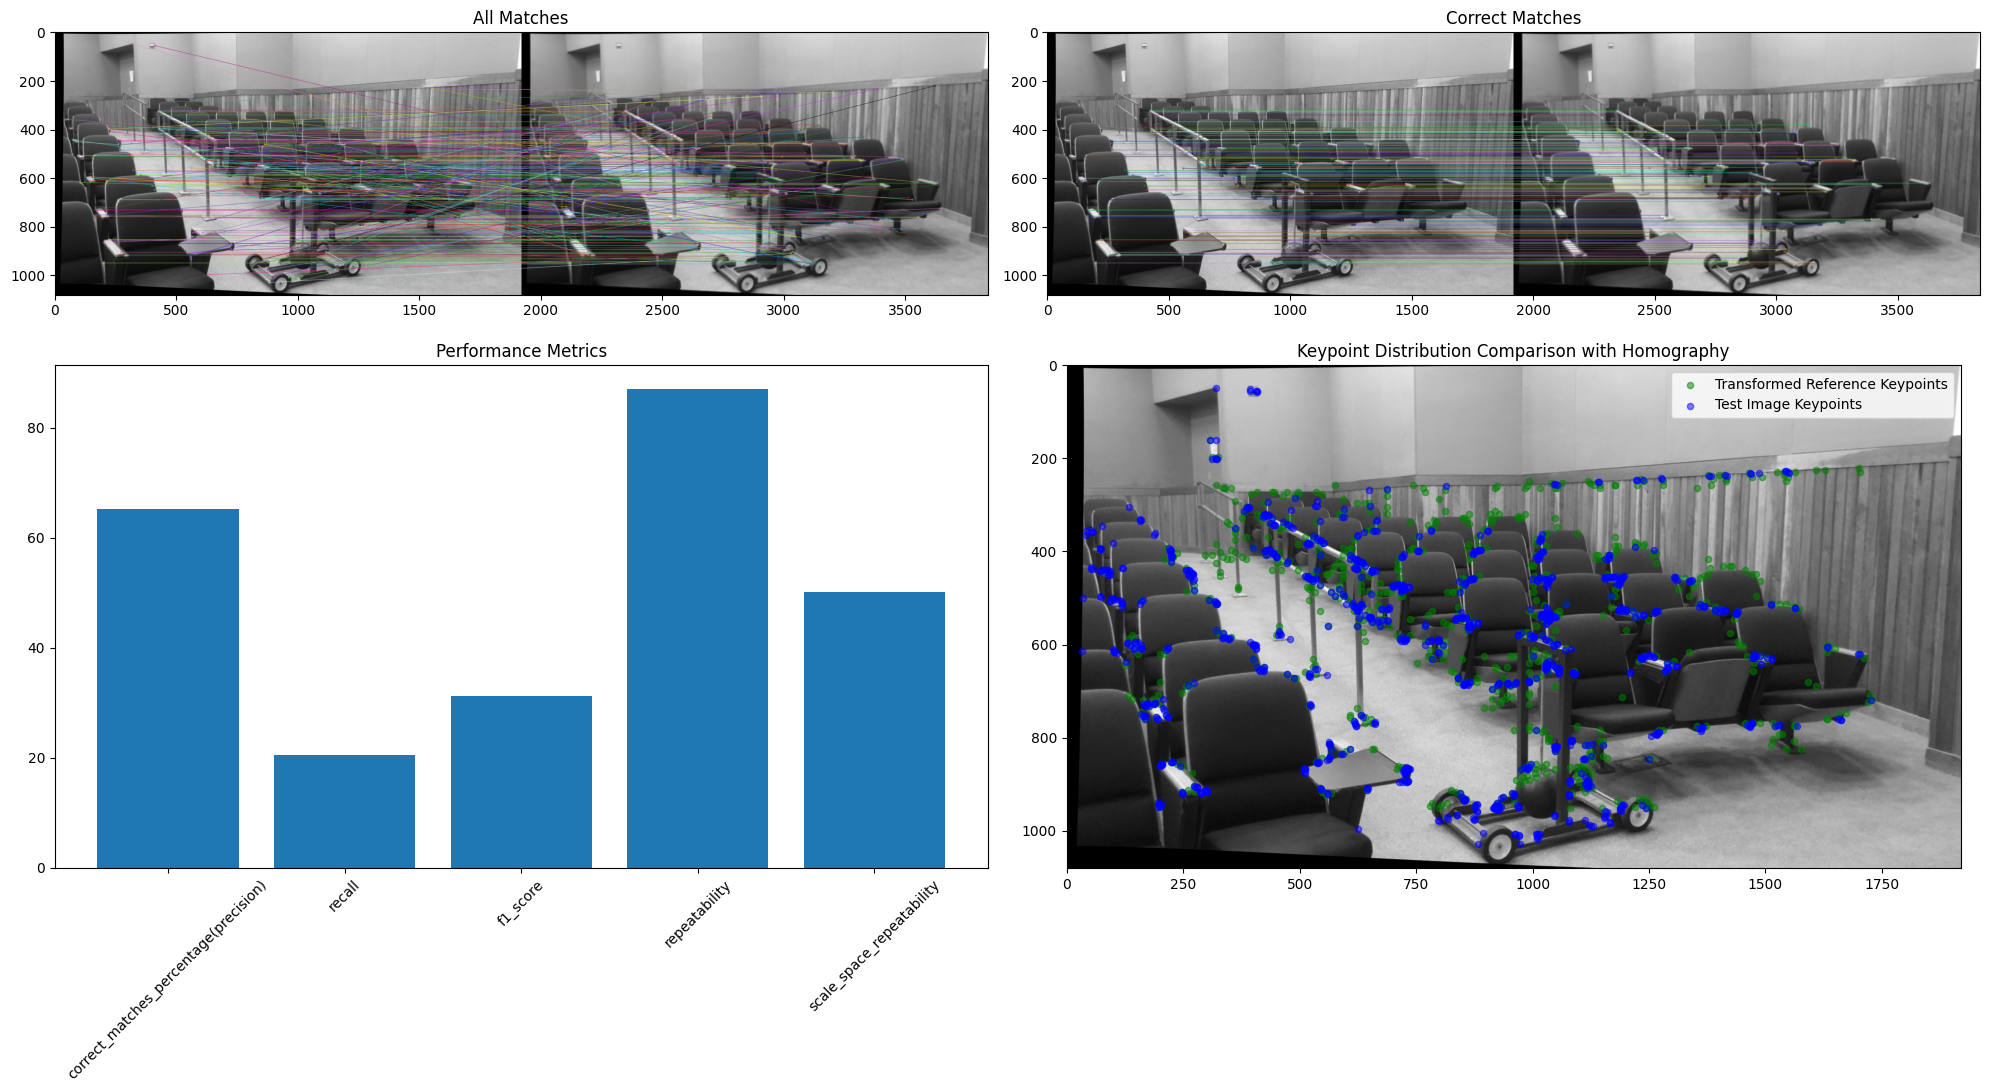


Feature Detection and Matching Evaluation:

Feature Detection Metrics:
Number of keypoints (Reference): 956
Number of keypoints (Test): 770
Detection time: 23.21 ms

Matching Metrics:
Total matches: 301
Matches percentage: 39.09%
Matching time: 22.68 ms

Performance Metrics:
Correct matches count: 196
Correct Matches percentage: 65.12%
Recall: 20.50%
F1 Score: 31.19%
Average localization error: 55.02 pixels
Repeatability: 87.03%
Scale-space repeatability: 50.10%
Total processing time: 45.89 ms


[[ 2.50040040e-01  8.21454504e-05  2.08359569e-03]
 [ 3.18713153e-05  2.50406930e-01 -2.28885438e-01]
 [ 1.98988258e-07  5.80447895e-07  1.00000000e+00]]


In [ ]:
#ORB

import cv2
import time
from google.colab.patches import cv2_imshow

# 이미지가 제대로 로드되지 않은 경우 처리
if img1 is None or img2 is None:
    print("Could not open or find the images!")
    exit()


# ORB 특징점 검출기 생성
orb = orb = cv2.ORB_create(
    nfeatures=500,           # 특징점의 최대 개수
    scaleFactor=1.2,         # 이미지 크기 축소 비율
    nlevels=8,               # 피라미드 레벨 수
    edgeThreshold=31,        # 경계에서 떨어진 거리
    firstLevel=0,            # 피라미드의 첫 번째 레벨
    WTA_K=2,                 # 비교할 BRIEF 패턴 개수
    scoreType=cv2.ORB_HARRIS_SCORE,  # 점수 방법 (HARRIS_SCORE 또는 FAST_SCORE)
    patchSize=31,            # 특징점 패치 크기
    fastThreshold=20         # FAST 검출기 임계값
)

# 특징점과 디스크립터 추출
start = time.time()
keypoints_1, descriptors_1 = orb.detectAndCompute(img1, None)
keypoints_2, descriptors_2 = orb.detectAndCompute(img2, None)
end = time.time()


descriptors_1, descriptors_2, match_result, matched_img, start_match, end_match = BFMatcher_bi(img1, img2, keypoints_1, keypoints_2, descriptors_1, descriptors_2)


print("="*50)
metrics, correct_matches, CH = Calculate_metrics_Homography(keypoints_1, keypoints_2, match_result, GTH, img1, img2, (end - start), (end_match - start_match))
Visualize_metrics_Homography(img1, img2, keypoints_1, keypoints_2, match_result, correct_matches, metrics, CH)
Print_metrics(metrics)
print(CH)